# Unsupervised Learning

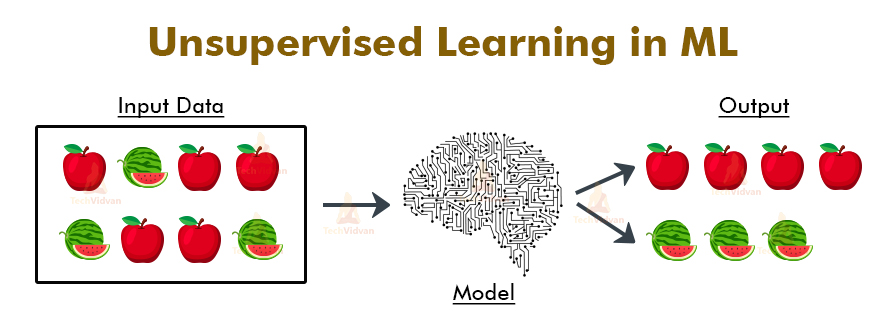

# Why ?



1.   It is similar to how a  human learns. It involves thinking by experiences, which moves it closer to real AI.
2.   It works on unlabeled data, which makes unsupervised learning further critical as real-world data is mostly unlabelled. 
3.   It helps look for useful insights from the data.





# Clustering

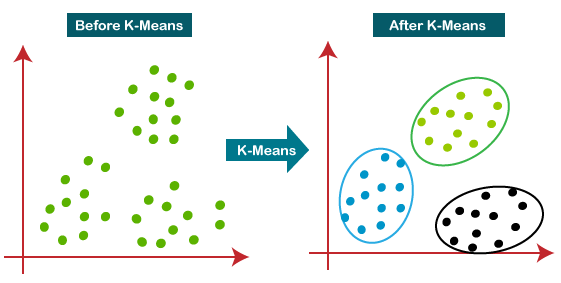

1.   Centroid-based Clustering

2.   Density-based Clustering

3.   Distribution-based Clustering

4.   Hierarchical Clustering




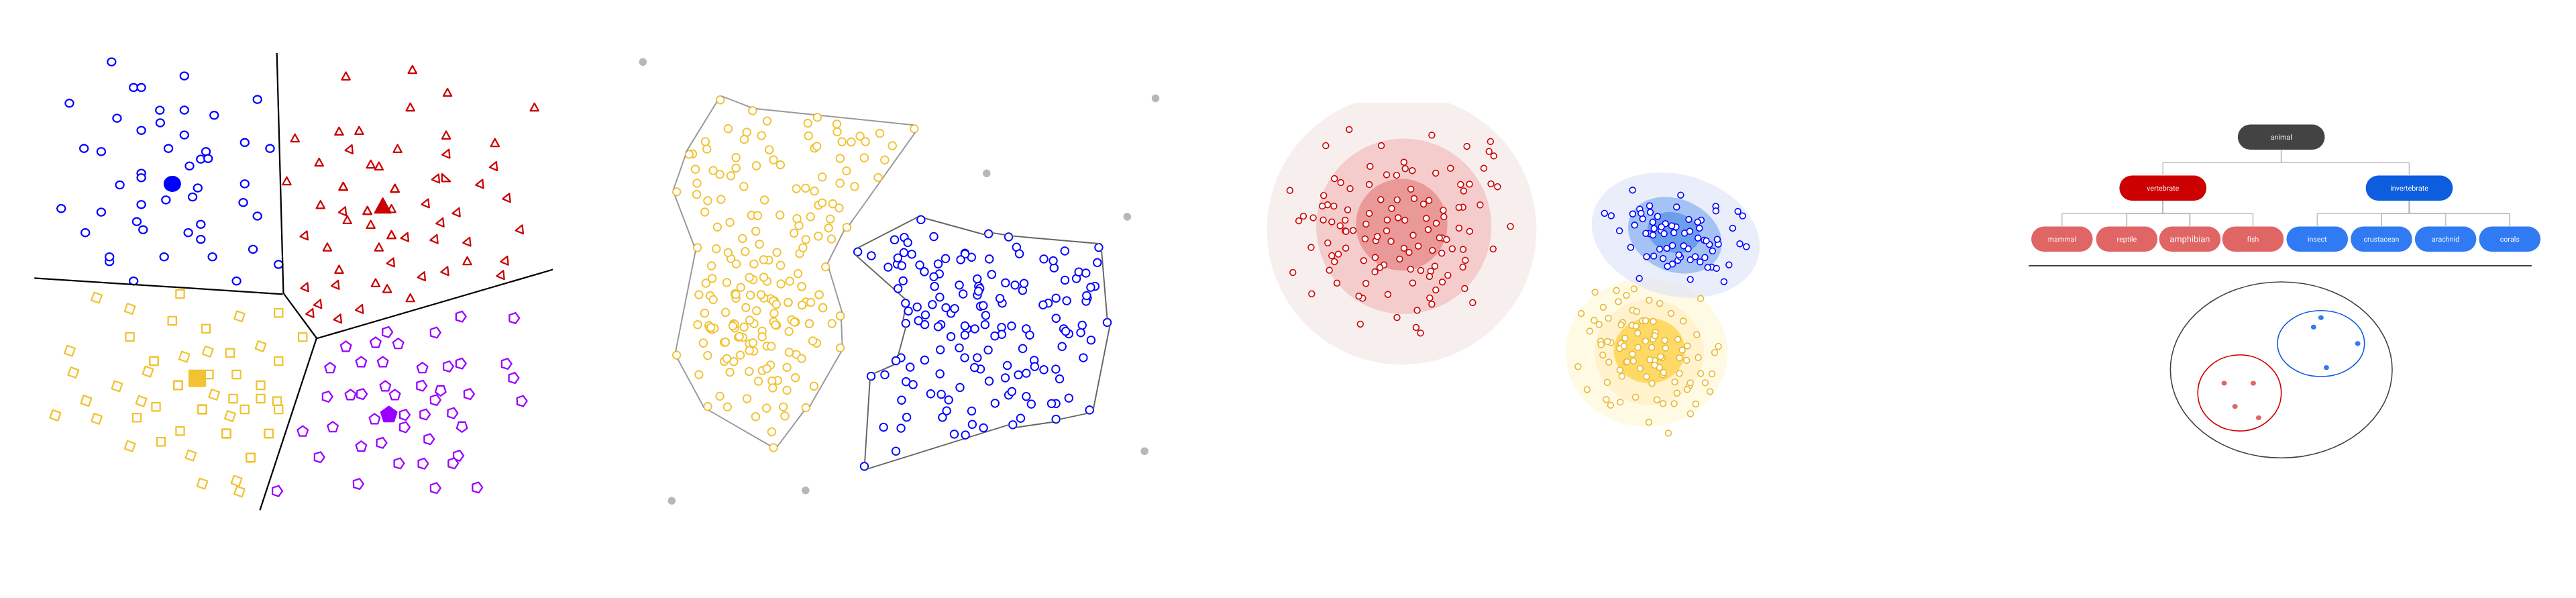

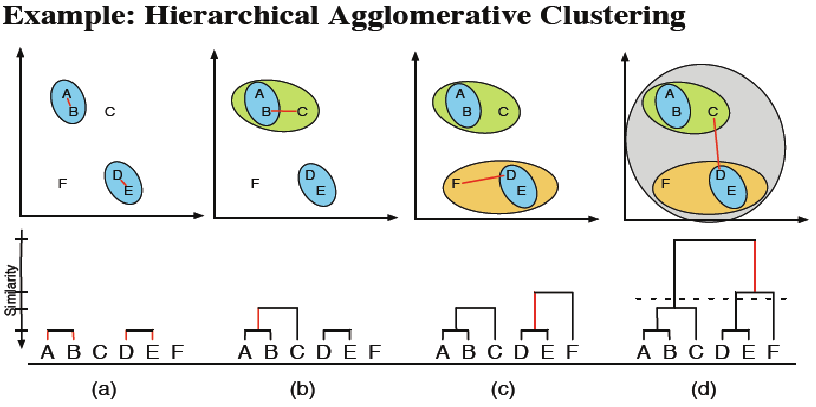

**K-means algorithm**
  1. Choose the number K to determine the number of clusters.
  2. Select arbitrary K points or centroids. (It can be different from the input dataset).
  3. Assign all data points to their nearest centroid. It will create the predetermined  K clusters.
  4. Calculate the variance and put a new centroid of each cluster.
  5. Repeat the third step. Keep reassigning each data point to the latest cluster’s closest centroid.
  6. If any reassignment happens, then move to step-4; else, end.
  7. Finally, your model is ready.

In [ ]:
import numpy as np
import scipy.io as sio
import scipy.misc as sm
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, NoNorm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score

%matplotlib inline

In [ ]:
data = sio.loadmat('/content/drive/MyDrive/UnsupLearn/kmeans.mat')

In [ ]:
# Examples with features x1 and x2
X = data['X']

Text(0.5, 1.0, 'K-means clustering of example dataset')

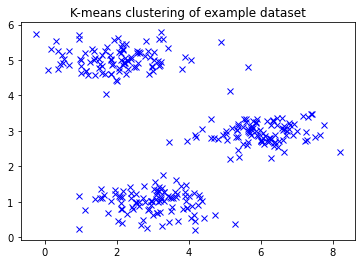

In [ ]:
# Plot training data
plt.plot(X[:,0], X[:,1], 'bx')
plt.title('K-means clustering of example dataset')

In [ ]:
# Run K-means clustering with 3 centroids
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [ ]:
# Obtain cluster centroids
centroids = kmeans.cluster_centers_

# Obtain cluster assignments
assignments = kmeans.labels_

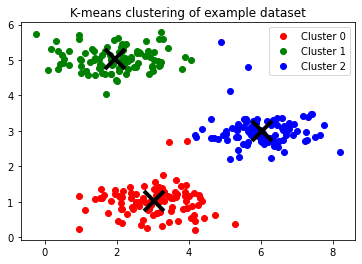

In [ ]:
def plot_cluster(X, centroids, assignments, cluster, color):
    '''Plot members and centroid of given cluster.'''
    plt.plot(X[assignments == cluster, 0], X[assignments == cluster, 1], f'{color}o', label=f'Cluster {cluster}')
    plt.plot(centroids[cluster, 0], centroids[cluster, 1], 'kx', ms=20, mew=4)
    
# Plot 3 clusters with colors red, green and blue
for i, color in enumerate('rgb'):
    plot_cluster(X, centroids, assignments, i, color)    

plt.title('K-means clustering of example dataset')
plt.legend()

# Anomaly detection

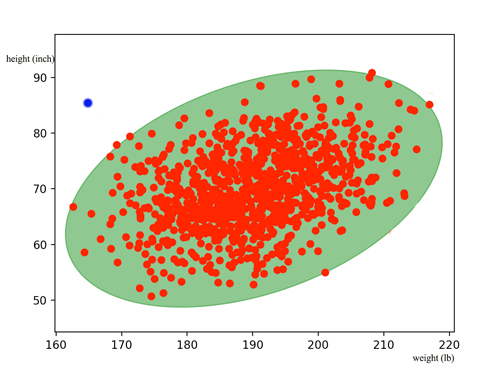

**Anomaly detection in 2D dataset**


In [ ]:
# Load example dataset (2D)
data = sio.loadmat('/content/drive/MyDrive/UnsupLearn/anomaly.mat')

In [ ]:
# Training dataset (307 examples)
X = data['X']

# Validation dataset (307 examples and labels)
X_val = data['Xval']
y_val = data['yval'].ravel()

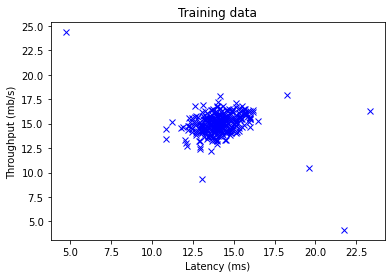

In [ ]:
def plt_desc(title):
    plt.title(title)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')    


# Plot training data
plt.plot(X[:,0], X[:,1], 'bx')
plt_desc('Training data')

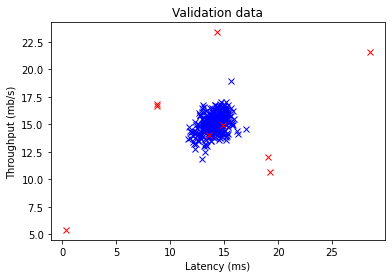

In [ ]:
# Plot neg. validation data (label 0)
plt.plot(X_val[y_val == 0,0], X_val[y_val == 0,1], 'bx')
plt_desc('Validation data')

# Plot pos. validation data (label 1, anomalies)
plt.plot(X_val[y_val == 1,0], X_val[y_val == 1,1], 'rx');

In [ ]:
# Fit a multivariate normal distribution using np.mean and np.cov
mvn = multivariate_normal(mean=np.mean(X, axis=0), cov=np.cov(X, rowvar=False))

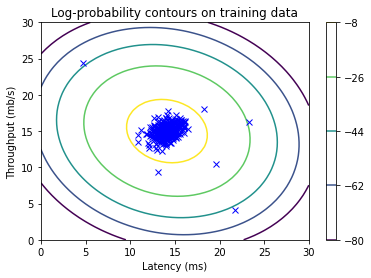

In [ ]:
# Create a meshgrid and calculate grid scores for countour plot
x, y = np.meshgrid(np.linspace(0, 30), np.linspace(0, 30))
xx = np.array([x.ravel(), y.ravel()]).T
z = mvn.logpdf(xx).reshape(x.shape)

# Plot training data
plt.plot(X[:,0], X[:,1], 'bx')

# Plot log-probability contours on training data (see color bar for value range)
CS = plt.contour(x, y, z, levels=np.linspace(-80, -8, 5))
plt.colorbar(CS)
plt_desc('Log-probability contours on training data')

In [ ]:
def estimate_epsilon(mvn, X_val, y_val):
    '''Estimate best epsilon from validation set log probabilities.
    
    This procedure chooses that epsilon value from a range of epsilon 
    values that maximizes the F1-score. 
    '''

    # Compute log probabilities for examples in validation set
    y_score = mvn.logpdf(X_val)
    y_score_min = y_score.min() + 1
    y_score_max = y_score.max()

    # Define a range of epsilon values for model evaluation. In 
    # contrast to the original exercise we use log-probabilities
    # for epsilon (instead of plain probability values).
    epsilon_range = np.linspace(y_score_min, y_score_max, 100)

    # Compute F1-scores for that range of epsilon values
    f1_scores = [f1_score(y_val, y_score < epsilon) for epsilon in epsilon_range]
    
    # Obtain index of maximum F1-score
    f1_max_idx = np.argmax(f1_scores)

    print(f'Best F1-score = {f1_scores[f1_max_idx]}')

    # Return the epsilon value that maximizes F1-score
    return epsilon_range[f1_max_idx]

In [ ]:
# Epsilon estimate (log-probability)
epsilon = estimate_epsilon(mvn, X_val, y_val)
epsilon

Best F1-score = 0.8750000000000001


-9.577969031851794

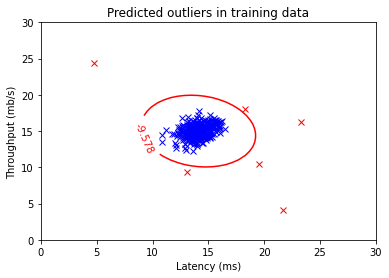

In [ ]:
# Predict outliers in training data
y_outlier = mvn.logpdf(X) < epsilon
y_outlier_neg = np.logical_not(y_outlier)

# Plot training data with predicted outliers in red
plt.plot(X[y_outlier_neg, 0], X[y_outlier_neg, 1], 'bx')
plt.plot(X[y_outlier, 0], X[y_outlier, 1], 'rx')


# Plot contour for best epsilon on training data
CS = plt.contour(x, y, z, levels=[epsilon], colors='r', linestyles='solid')
plt.clabel(CS)
plt_desc('Predicted outliers in training data')

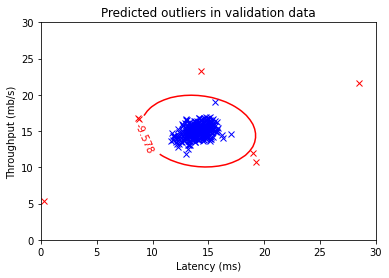

In [ ]:
# Predict outliers in validation data
y_outlier = mvn.logpdf(X_val) < epsilon
y_outlier_neg = np.logical_not(y_outlier)

# Plot validation data with predicted outliers in red
plt.plot(X_val[y_outlier_neg, 0], X_val[y_outlier_neg, 1], 'bx')
plt.plot(X_val[y_outlier, 0], X_val[y_outlier, 1], 'rx')

# Plot contour for best epsilon on validation data
CS = plt.contour(x, y, z, levels=[epsilon], colors='r', linestyles='solid')
plt.clabel(CS)
plt_desc('Predicted outliers in validation data')

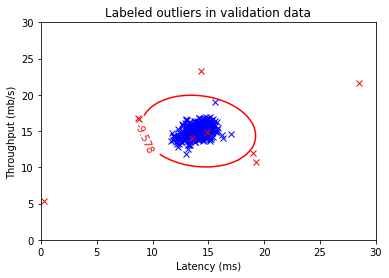

In [ ]:
# Use outlier labels in validation data
y_outlier = y_val == 1
y_outlier_neg = np.logical_not(y_outlier)

# Plot validation data with labeled outliers in red
plt.plot(X_val[y_outlier_neg, 0], X_val[y_outlier_neg, 1], 'bx')
plt.plot(X_val[y_outlier, 0], X_val[y_outlier, 1], 'rx')

# Plot contour for best epsilon on validation data
CS = plt.contour(x, y, z, levels=[epsilon], colors='r', linestyles='solid')
plt.clabel(CS)
plt_desc('Labeled outliers in validation data')

# Dimensionality reduction

**Principal Component Analysis**
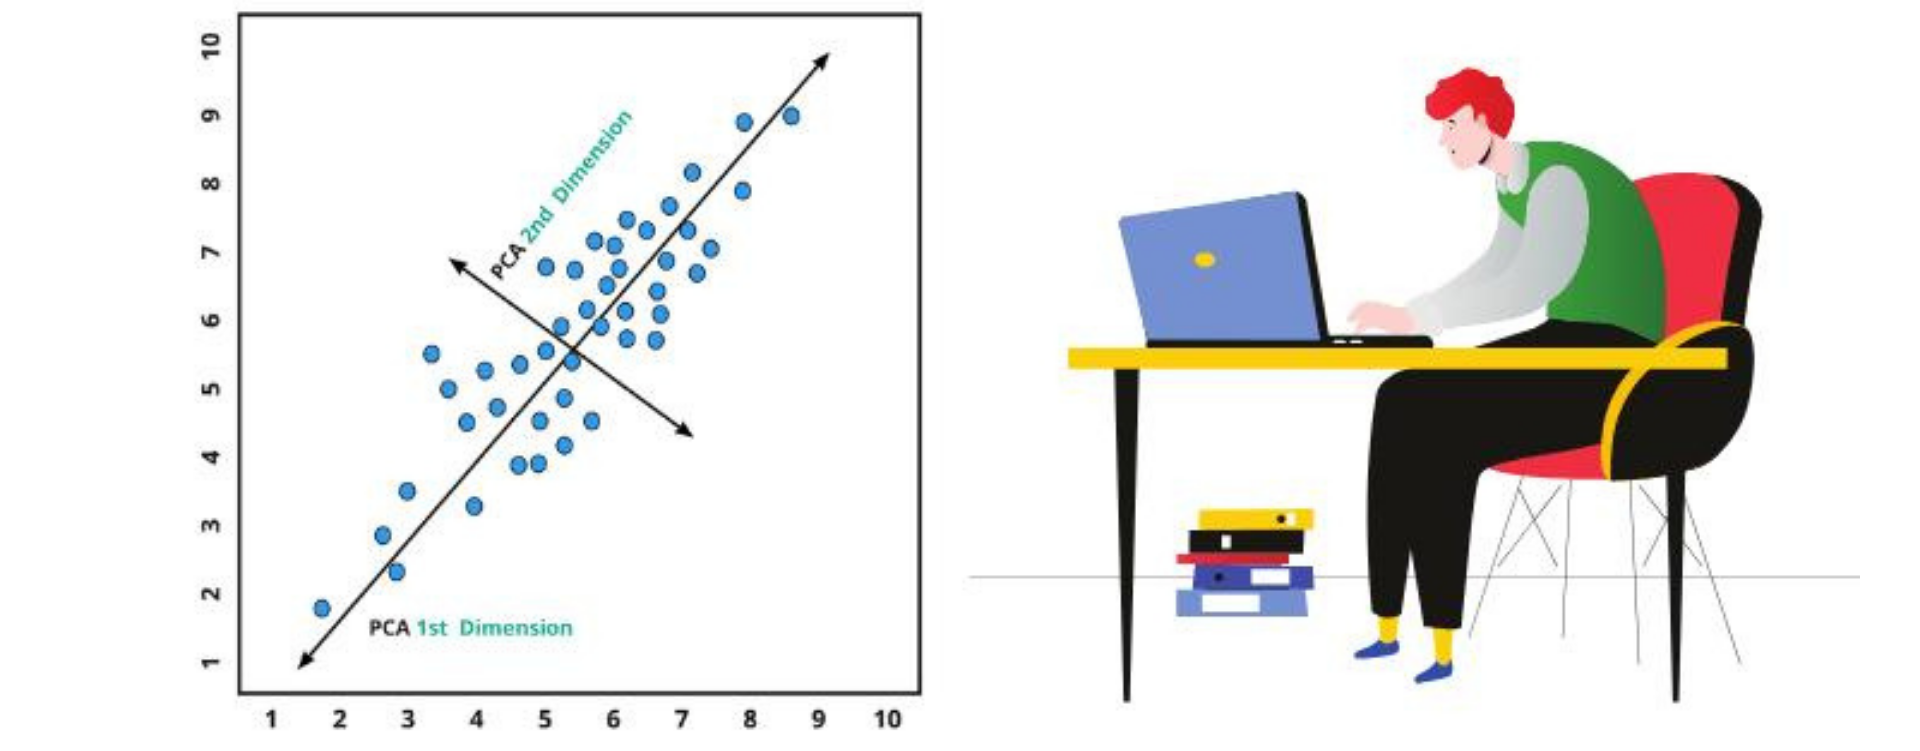

  1. Arrange data into a structure
  2. Normalizing the given data
  3. Calculate the Covariance of Z
  4. Determine the EigenValues and EigenVectors
  5. Sort the calculated EigenVectors
  6. Assess the new features Or Principal Components
  7. Drop unimportant features from the new dataset.

In [ ]:
# Load example dataset
data = sio.loadmat('/content/drive/MyDrive/UnsupLearn/pca.mat')

In [ ]:
# Examples with features x1 and x2
X = data['X']

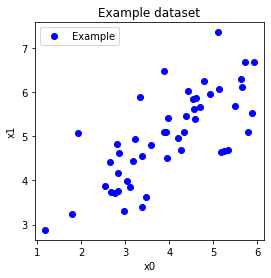

In [ ]:
# Create a figure and an Axes object (for later re-use)
fig, ax = plt.subplots()

# Plot example dataset
ax.plot(X[:,0], X[:,1], 'bo', label='Example')
ax.set_title('Example dataset')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_aspect('equal', adjustable='box')
ax.legend()

In [ ]:
# Standard scaler instance
scaler = StandardScaler()

# PCA instance
pca = PCA()

# PCA pipeline with data pre-processing to zero mean and unit variance
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca)])

In [ ]:
# Learn principal components
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

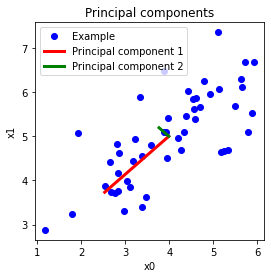

In [ ]:
# The length of the plotted principal components should 
# correspond to their eigenvalues (explained variance). 
components = pca.components_ * pca.explained_variance_.reshape(-1,1)

# Transform principal components back onto original data 
components = scaler.inverse_transform(components)

# Obtain original data mean values
mean = scaler.mean_

# Plot transformed principal components on original data
ax.set_title('Principal components')
ax.plot([mean[0], components[0,0]], 
        [mean[1], components[0,1]], 
        'r-', lw=3, label='Principal component 1')
ax.plot([mean[0], components[1,0]], 
        [mean[1], components[1,1]], 
        'g-', lw=3, label='Principal component 2')
ax.legend()


# Show figure with original data and principal components
fig

In [ ]:
# For 2D -> 1D reduction, set number 
# of principal components to 1.
pca.n_components = 1

# Re-learn first principal component
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=1))])

In [ ]:
# Project data onto first principal component
X_red = pipeline.transform(X)

# Result is a vector (m*1 array) X_red
X_red.shape

(50, 1)

In [ ]:
# Transform projections back into 2D space
X_rec = pipeline.inverse_transform(X_red)

# Result is a matrix (m*2 array) X_rec
X_rec.shape

(50, 2)

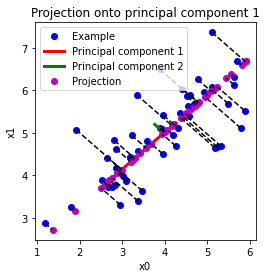

In [ ]:
# Plot projections onto first principal component in 2D space
ax.plot(X_rec[:,0], X_rec[:,1], 'mo', label='Projection')

# Plot lines between original data and their projections
for i in range(X.shape[0]):
    ax.plot([X[i,0], X_rec[i,0]], [X[i,1], X_rec[i,1]], 'k--')

ax.set_title('Projection onto principal component 1')
ax.legend()    
    
fig

# Association
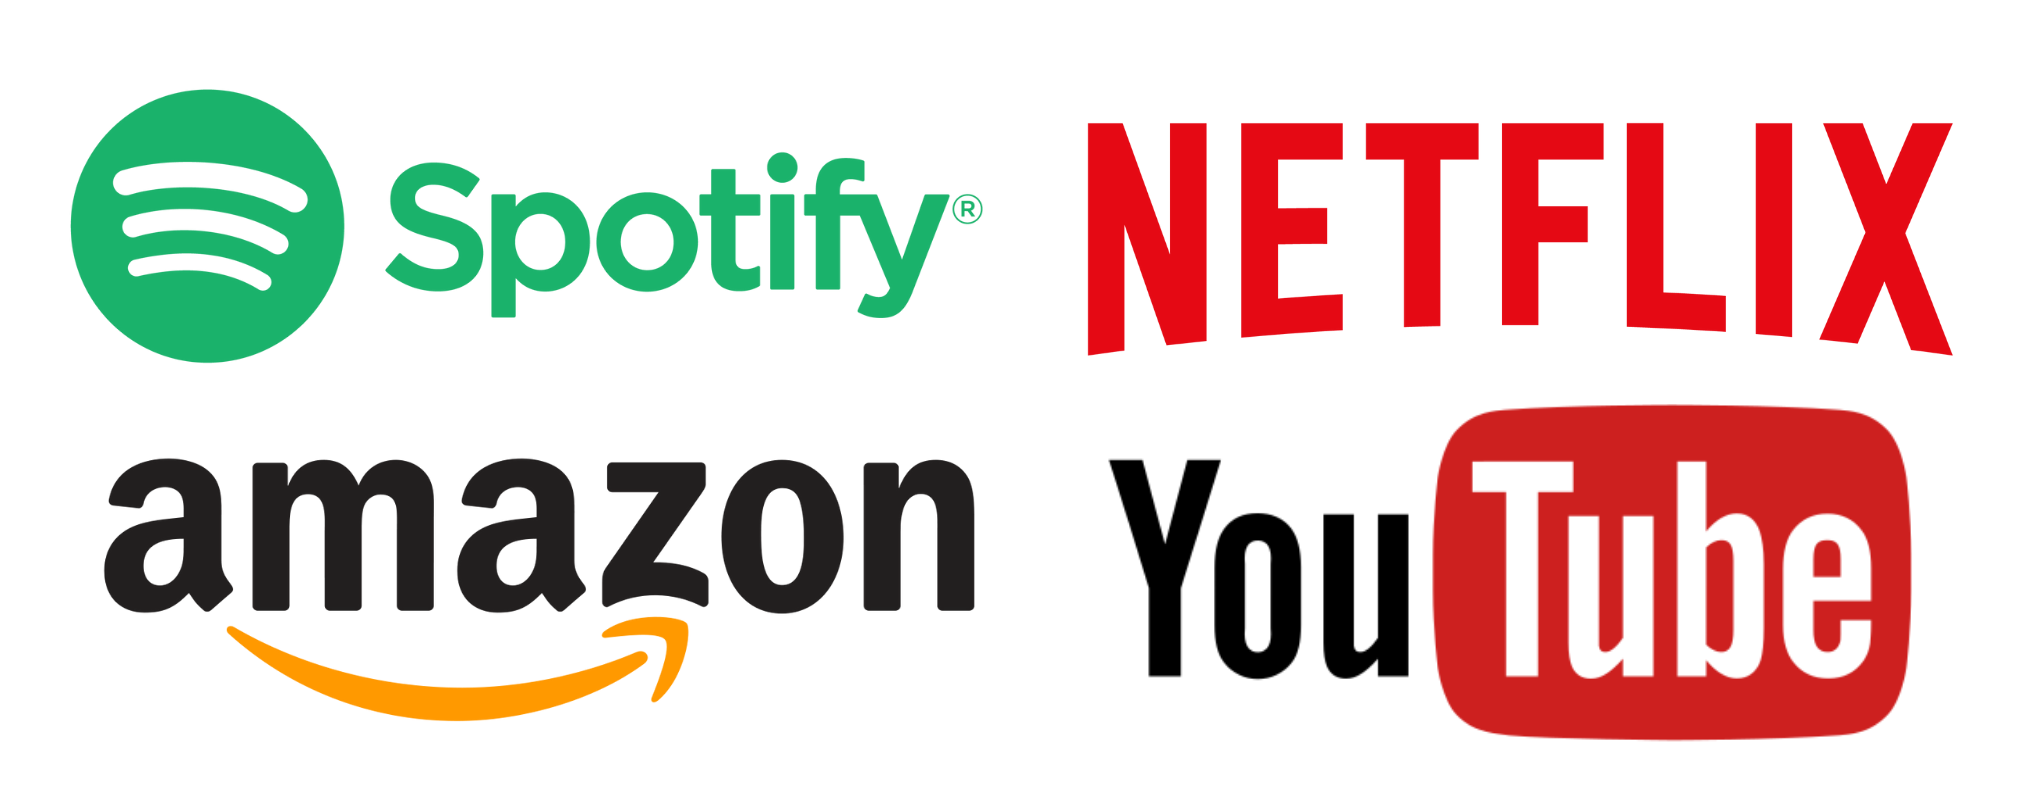

Association rule algorithms count the frequency of complimentary occurrences, or associations, across a large collection of items or actions. The goal is to find associations that take place together far more often than you would find in a random sampling of possibilities. This rule-based approach is a fast and powerful tool for mining categorized, non-numeric databases.

